In [1]:
import numpy as np
import matplotlib.pyplot as plt

from latent_process import MaternProcess
from filtsmooth import KalmanFilter
from data import Dataset

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

## Notebook Objectives:
In this notebook we:


1) demonstrate how to use the filtering and smoothing algorithms with a latent Matern 5/2 process and discrete observations (temporal GPs)


2) compare the results of GP regression (custom and sklearn) with the temporal GPs and show they are equivalent methods in terms of results

In [2]:
func = lambda grid : np.sin(2 * np.pi * grid)
dist = 'normal'
params = {"loc": 0, "scale": 0.5}
tmin, tmax = (0.5, 4.0)
num_data_pts = 80
dataset = Dataset(tmin=tmin, tmax=tmax, num_data_pts=num_data_pts, func=func, dist=dist, params=params)

obs_grid, obs = dataset.observations()

In [3]:
#---------------latent process------------------
n = 1 
p = 2 
magnitude, lengthscale = (3, 0.4)
mp = MaternProcess(n=n, p=p, magnitude=magnitude, lengthscale=lengthscale)

#--------------observation process---------------------
output_dim = 1 if len(obs.shape)==1 else obs.shape[-1] 
obs_noise = 1.7
H = np.concatenate([np.eye(n), np.zeros((n, n * p))], axis=1)
R = obs_noise * np.eye(output_dim)

#------------filtering & smoothing---------------------
subdiv = 1
filter = KalmanFilter(obs_grid=obs_grid, obs=obs, latent_process=mp, subdiv=subdiv, H=H, R=R)
m_filt, P_filt, m, P = filter.filtsmooth()

m_filt_hat = m_filt[:, 0].flatten()
m_smooth_hat = m[:, 0].flatten()

#----sklearn prediction (standard GP regression)-------
kernel =  magnitude * Matern(length_scale=lengthscale, nu=p) 
kernel.set_params(k1__constant_value_bounds='fixed', k2__length_scale_bounds='fixed') #preventing hyperparameter optimization
gp_sklearn = GaussianProcessRegressor(kernel, alpha=obs_noise)
gp_sklearn.fit(obs_grid.reshape(-1,1), obs.reshape(-1,1))
m_sklearn = gp_sklearn.predict(filter.filter_grid.reshape(-1,1))

#----Custom posterior for GP regression-----------------
K = kernel(obs_grid.reshape(-1,1))
my_P = K @ np.linalg.inv(K + obs_noise * np.eye(len(obs))) @ (obs_noise * np.eye(len(obs)))
my_mu = K @ np.linalg.inv(K + obs_noise * np.eye(len(obs))) @ obs

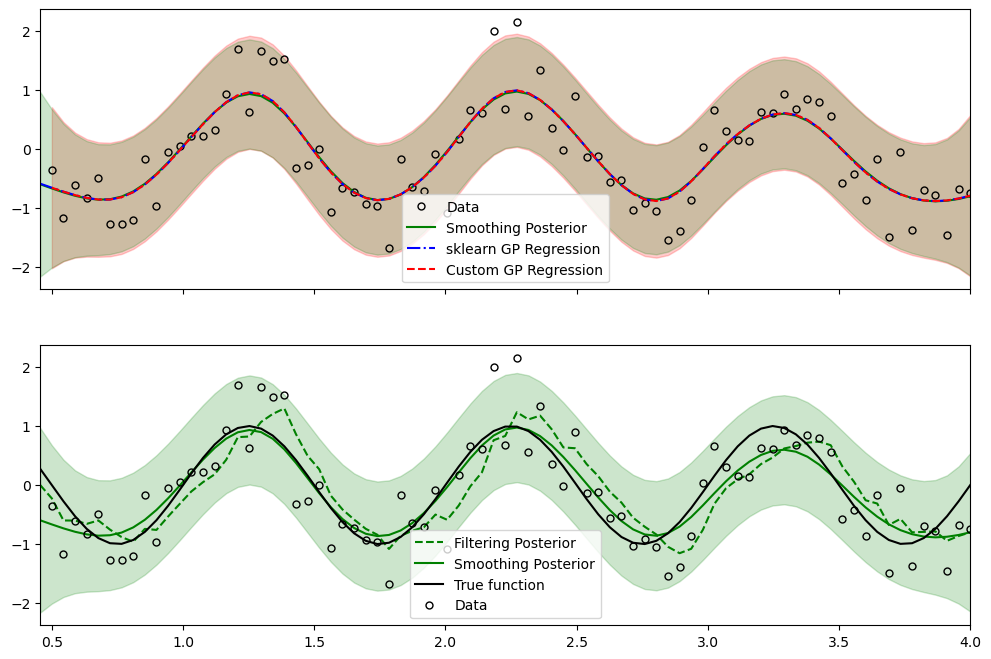

In [5]:
#-------------------plotting---------------------------
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True)

#axis 0: compare Temporal GPs with GP regression
axs[0].plot(obs_grid, obs, 'o', markersize=5, color='black', fillstyle = 'none', label='Data')
axs[0].plot(filter.filter_grid, m_smooth_hat, '-', color='green', label = 'Smoothing Posterior')
axs[0].plot(filter.filter_grid, m_sklearn, linestyle='dashdot', color='blue', label="sklearn GP Regression")
axs[0].plot(obs_grid, my_mu, '--', color='red', label='Custom GP Regression')
axs[0].fill_between(obs_grid, my_mu - 2 * np.sqrt(np.diag(my_P)), my_mu + 2 * np.sqrt(np.diag(my_P)), color='red', alpha=0.2)
axs[0].fill_between(filter.filter_grid, m_smooth_hat - 2 * np.sqrt(P[:, 0, 0]), m_smooth_hat + 2 * np.sqrt(P[:, 0, 0]), alpha=0.2, color='green')


#axis 1: compare Temporal GP with true function
axs[1].plot(filter.filter_grid, m_filt_hat, '--', color = 'green', label='Filtering Posterior')
axs[1].plot(filter.filter_grid, m_smooth_hat, '-', color='green', label = 'Smoothing Posterior')
axs[1].fill_between(filter.filter_grid, m_smooth_hat - 2 * np.sqrt(P[:, 0, 0]), m_smooth_hat + 2 * np.sqrt(P[:, 0, 0]), alpha=0.2, color='green')
axs[1].plot(filter.filter_grid, func(filter.filter_grid), color='black', label='True function')
axs[1].plot(obs_grid, obs, 'o', markersize=5, color='black', fillstyle = 'none', label='Data')

axs[0].legend()
axs[1].legend()
axs[1].set_xlim(filter.filter_grid[0], filter.filter_grid[-1]);